# Import Libraries

In [1]:
import torch # standard basic library for pytorch
import torch.autograd # need Variable class
import torch.nn as nn # need the basic neural net module
import torch.nn.functional as F # imported for the conv1d function
import torch.nn.parameter as Parameter

import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

# Normal Convolution

In [2]:
# convFilter = torch.FloatTensor([8,2]) # use [8,2] for test kernel
# convFilter = torch.unsqueeze(convFilter,0) # unsqueeze twice to make filter a 3 dimensional 1x1x2 filter
# convFilter = torch.unsqueeze(convFilter,0)
# convInput = torch.unsqueeze(torch.autograd.Variable(torch.FloatTensor([3,7,6,4])),0) # use [3,7,6,4] as test input
# convInput = torch.unsqueeze(convInput,0) #unsqueeze twice to make input 3D 1x1x4 for the Conv1D class
# print(convInput)


# conv = torch.nn.Conv1d(1,1,2,padding = 0, bias = False) # set bias to false for now since no learning is required yet
# conv.weight = torch.nn.Parameter(convFilter) # set weight of conv filter to be what was specified
# print(conv.weight)

# convOutput = conv(convInput) # convolve input with filter --> this should give non-causal convolution
# print(convOutput)

# Causal Convolution

In [3]:
class CausalConv(torch.nn.Conv1d): # a class for causal convolution exclusively
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(CausalConv,self).__init__(in_channels, out_channels, kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias) # initialise with Conv1d init variables
        self.causality_padding = kernel_size - 1 # padding size depends on kernel size; output at t depend on input t-n...input t
        
    def forward(self, inputs):
        inputs = F.pad(inputs, (self.causality_padding,0,0,0))
        return F.conv1d(inputs, self.weight)

# Test for Causal Convolution

In [4]:
# causalConvInput = torch.ones(1,2,5)
# print(causalConvInput)
# causal_conv = CausalConv(2,2,3)
# causal_conv_output = causal_conv(causalConvInput)

# print(causal_conv_output)

# 1x1 Convolution

In [5]:
class OneConv(torch.nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True):
        super(OneConv, self).__init__(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias)
        
    def forward(self, inputs):
        return super(OneConv,self).forward(inputs)

# 1x1 Convolution Testing

In [6]:
# oneInput = torch.autograd.Variable(torch.ones(1,1,5))
# print(oneInput)
# oneConv = OneConv(1,1)
# oneOutput = oneConv(oneInput)
# print(oneOutput)

# Wavenet

In [7]:
class WaveNet(nn.Module):
    def __init__(self, dilation, causalKernel, dilationStack):
        super(WaveNet, self).__init__()
        self.dilations = [2**d for d in range(dilation)] * dilationStack
        self.causalConv = []
        self.oneConv = OneConv(1,1)
        self.output = []
        for i in range(dilation*dilationStack):
            self.causalConv.append(CausalConv(1,1,causalKernel,dilation = self.dilations[i]))
        
    def forward(self, inputs):
        inputs = torch.autograd.Variable(inputs)
        for i in range(len(self.causalConv)):
            residualInput = inputs # store inputs for residual addition at the end
            inputs = self.causalConv[i](inputs) # causal convolution with dilation varied
            inputs = self.gated_activation_unit(inputs) # gated activation unit, product of tanh and sigmoid
            inputs = self.oneConv(inputs) # a 1x1 convolution 
            self.output.append(inputs) # store output of 1x1 convolution for skip connections
#             print("output = \n---", self.output[i], "---\n residual = ",residualInput)
            inputs = self.output[i] + residualInput # add stored output with residual input at the start
        return self.skip_connections(self.output)
    
    def gated_activation_unit(self,inputs):
        return torch.tanh(inputs) * torch.sigmoid(inputs)
    
    def skip_connections(self,x):
        s = nn.Softmax(0) #added for experimentation
        return (self.oneConv(F.relu(self.oneConv(F.relu(sum(x)))))) # avoid softmax here, use cross entropy function with its own softmax later on

In [8]:
wNet = WaveNet(10,2,6)
# print(len(wNet.causalConv))
wNet(torch.randn(1,1,5000))

Variable containing:
( 0  ,.,.) = 
 -0.1385 -0.1385 -0.1385  ...  -0.1385 -0.1385 -0.1385
[torch.FloatTensor of size 1x1x5000]

# Training

## Data generator

In [9]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4000)
        ys = np.sin(xs) #+ np.random.rand(4000)*0.2-0.1
        ys = ys.astype(np.float32) # default is np.float64
        x = torch.from_numpy(ys).view(1,1,-1)
#         x = torch.from_numpy(ys[:3999]).view(1,1,-1)
#         y = torch.from_numpy(ys[1:4000]).view(1,1,-1)
        if (torch.cuda.is_available() and CUDA):
            x = x.cuda()
            y = y.cuda()
            
        yield x #, y #Variable(x), Variable(y)

g = batch_generator()

## Mu Decoder and Encoder

In [10]:
# non-linear encoder (quantiser) - reduce the dynamic range of audio signal 
def mu_encoder(x,mu):
    output = torch.sign(x) * ((torch.log1p(1+mu*torch.abs(x)))/(torch.log1p(1+torch.ones(1,1,max(x.size()))*mu)))
    return output

def mu_decoder(x):
    return x


## Data Plotting

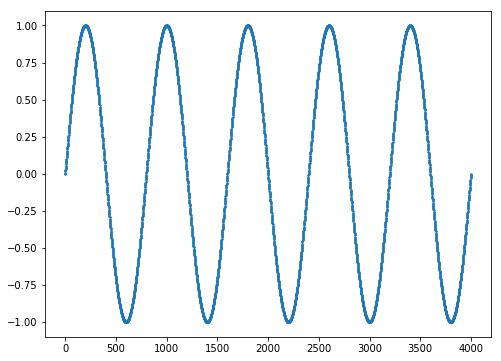

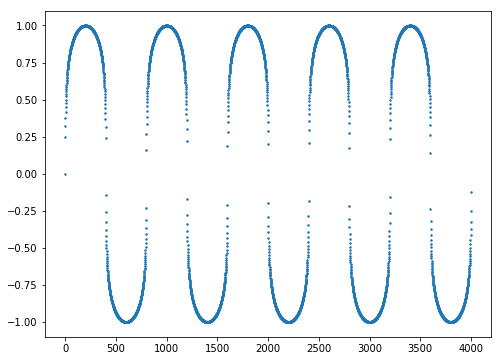

In [11]:
x = next(g)
plt.figure(figsize=[8,6])
plt.plot(torch.autograd.Variable(x).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_encoder(x,255)
plt.figure(figsize=[8,6]) 
plt.plot(torch.autograd.Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

# temp = mu_decoder(temp)
# plt.figure(figsize=[8,6])
# plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)